# Confuences Lab

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point, LineString
from shapely.ops import nearest_points
import mapclassify

### Get confluences points

In [2]:
lats = [lat for lat in range(-90, 100, 10)]
lngs = [lng for lng in range(-180, 190, 10)]
coords = [(lat, lng) for lng in lngs for lat in lats]

In [3]:
points_df = pd.DataFrame(coords, columns=['lat', 'lng'])
points_geometry = [Point(xy) for xy in zip(points_df.lng, points_df.lat)]
crs = {'init': 'epsg:4326'}
points = gpd.GeoDataFrame(points_df, crs=crs, geometry=points_geometry)
points.head()

/home/ramiro/projects/confluences/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,lat,lng,geometry
0,-90,-180,POINT (-180.00000 -90.00000)
1,-80,-180,POINT (-180.00000 -80.00000)
2,-70,-180,POINT (-180.00000 -70.00000)
3,-60,-180,POINT (-180.00000 -60.00000)
4,-50,-180,POINT (-180.00000 -50.00000)


In [4]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

Text(0.5, 1.0, 'Confluences')

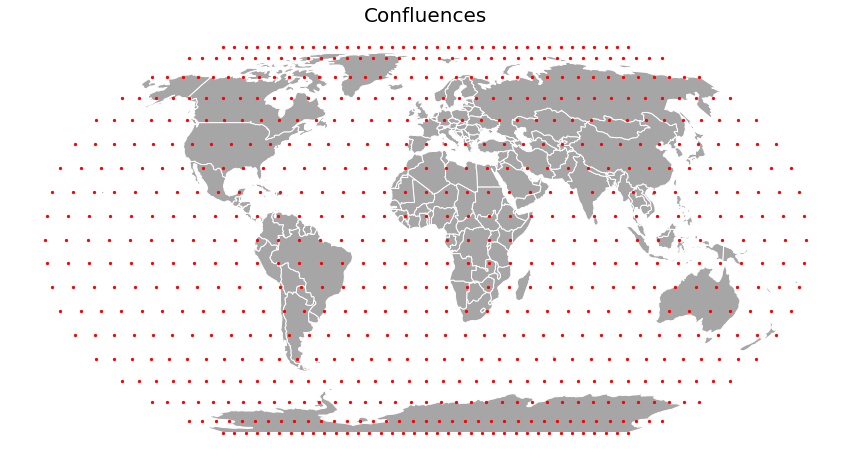

In [57]:
fig, ax = plt.subplots(figsize=(15, 15))

basemap = world.to_crs('+proj=robin').plot(ax=ax, color='#a6a6a6', edgecolor='white')
points.to_crs('+proj=robin').plot(ax=ax, marker='o', color='red', markersize=5)
plt.axis('off')
ax.set_title("Confluences", fontsize=20)

### Get reticule/grid

In [6]:
meridians = [
    (Point(lng, min(lats)), Point(lng, max(lats))) for lng in lngs
]
paralells = [
    (Point(min(lngs), lat), Point(max(lngs), lat)) for lat in lats
]

In [7]:
meridians_df = pd.DataFrame(meridians, columns=['origin', 'destination'])
paralells_df = pd.DataFrame(paralells, columns=['origin', 'destination'])
grid_df = pd.concat([meridians_df, paralells_df])
grid_df['lines'] = grid_df.apply(lambda row: LineString([row.origin, row.destination]), axis=1)
grid = gpd.GeoDataFrame(grid_df, crs=crs, geometry=grid_df['lines'])
grid.head()

/home/ramiro/projects/confluences/env/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,origin,destination,lines,geometry
0,POINT (-180 -90),POINT (-180 90),"LINESTRING (-180 -90, -180 90)","LINESTRING (-180.00000 -90.00000, -180.00000 9..."
1,POINT (-170 -90),POINT (-170 90),"LINESTRING (-170 -90, -170 90)","LINESTRING (-170.00000 -90.00000, -170.00000 9..."
2,POINT (-160 -90),POINT (-160 90),"LINESTRING (-160 -90, -160 90)","LINESTRING (-160.00000 -90.00000, -160.00000 9..."
3,POINT (-150 -90),POINT (-150 90),"LINESTRING (-150 -90, -150 90)","LINESTRING (-150.00000 -90.00000, -150.00000 9..."
4,POINT (-140 -90),POINT (-140 90),"LINESTRING (-140 -90, -140 90)","LINESTRING (-140.00000 -90.00000, -140.00000 9..."


Text(0.5, 1.0, 'Grid')

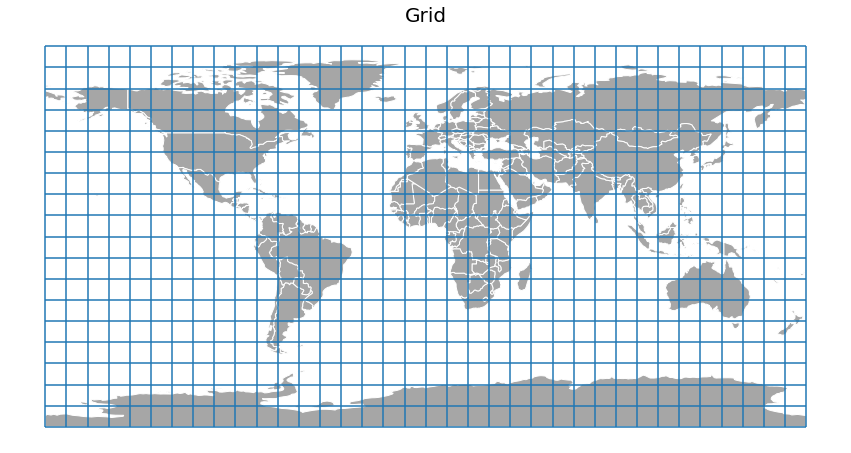

In [56]:
fig, ax = plt.subplots(figsize=(15, 15))
basemap = world.plot(ax=ax, color='#a6a6a6', edgecolor='white')
grid.plot(ax=ax)
plt.axis('off')
ax.set_title("Grid", fontsize=20)

### Get country count and density

In [9]:
world['count'] = world['geometry'].apply(
    lambda row: np.sum(points['geometry'].intersects(row))
)
world['density'] = world['count']/world['geometry'].area

In [10]:
world.sort_values(by='density', ascending=False).head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry,count,density
125,3047987,Europe,Albania,ALB,33900.0,"POLYGON ((21.02004 40.84273, 20.99999 40.58000...",1,0.313956
61,12413867,Africa,Guinea,GIN,16080.0,"POLYGON ((-13.70048 12.58618, -13.21782 12.575...",1,0.050541
59,27499924,Africa,Ghana,GHA,120800.0,"POLYGON ((0.02380 11.01868, -0.04978 10.70692,...",1,0.050065
168,39570125,Africa,Uganda,UGA,84930.0,"POLYGON ((33.90371 -0.95000, 31.86617 -1.02736...",1,0.050059
44,16290913,South America,Ecuador,ECU,182400.0,"POLYGON ((-75.37322 -0.15203, -75.23372 -0.911...",1,0.049062


In [11]:
world[['name', 'count', 'density']].sort_values(by='count', ascending=False).head(10)

,name,count,density
159,Antarctica,78,0.012938
18,Russia,26,0.008858
3,Canada,17,0.009924
4,United States of America,12,0.010693
139,China,10,0.010475
22,Greenland,8,0.011808
29,Brazil,7,0.009857
137,Australia,7,0.010064
8,Indonesia,4,0.027002
5,Kazakhstan,4,0.012100


In [12]:
world[['name', 'count', 'density']].sort_values(by='density', ascending=False).head(10)

,name,count,density
125,Albania,1,0.313956
61,Guinea,1,0.050541
59,Ghana,1,0.050065
168,Uganda,1,0.050059
44,Ecuador,1,0.049062
105,Kyrgyzstan,1,0.047331
68,Gabon,1,0.045664
21,Norway,3,0.033151
48,Zimbabwe,1,0.030979
156,Paraguay,1,0.028225


In [13]:
world[['name', 'count', 'density']].loc[world['count'] > 1].sort_values(by='density', ascending=False).head(10)

,name,count,density
21,Norway,3,0.033151
8,Indonesia,4,0.027002
124,Turkey,2,0.024052
10,Chile,2,0.023119
15,Chad,2,0.018662
25,South Africa,2,0.017743
27,Mexico,3,0.017123
164,Libya,2,0.013436
159,Antarctica,78,0.012938
5,Kazakhstan,4,0.012100


Text(0.5, 1.0, 'Confluences Density')

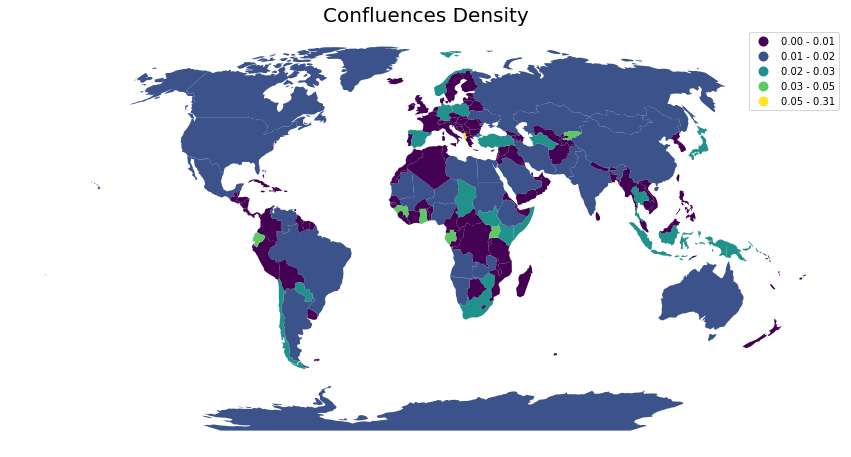

In [51]:
fig, ax = plt.subplots(figsize=(15, 15))

world.to_crs('+proj=robin').plot(column='density', scheme="fisher_jenks", figsize=(15,10), ax=ax, legend=True)
plt.axis('off')
ax.set_title("Confluences Density", fontsize=20)

### Get nearest cities

In [15]:
url = 'https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_populated_places.zip'
cities = gpd.read_file(url)

In [16]:
from scipy.spatial import cKDTree

# from https://gis.stackexchange.com/a/301935/41250
def get_nearest(gdf_1, gdf_2):
    n_1 = np.array(list(zip(gdf_1.geometry.x, gdf_1.geometry.y)) )
    n_2 = np.array(list(zip(gdf_2.geometry.x, gdf_2.geometry.y)) )
    btree = cKDTree(n_2)
    dist, idx = btree.query(n_1, k=1)
    gdf = pd.concat(
        [gdf_1.reset_index(drop=True), gdf_2.loc[idx, gdf_2.columns != 'geometry'].reset_index(drop=True),
         pd.Series(dist, name='distance')], axis=1)
    return gdf

In [17]:
nearest = get_nearest(points, cities)

In [18]:
nearest_df = nearest[['NAME', 'distance']].drop_duplicates(['NAME'])

In [19]:
nearest_df = nearest_df.merge(cities[['geometry', 'NAME', 'ADM0NAME']], on='NAME', how='left')

In [20]:
nearest_cities = gpd.GeoDataFrame(nearest_df, geometry='geometry')

In [21]:
nearest_cities.head()

,NAME,distance,geometry,ADM0NAME
0,Waitangi,46.116866,POINT (-176.36958 -44.02625),Chatham Islands
1,Raoul Island Station,2.206244,POINT (-177.92641 -29.24651),Kermadec Islands
2,Nukualofa,4.913167,POINT (-175.22056 -21.13851),Tonga
3,Atafu,7.641435,POINT (-172.49767 -8.54862),Tokelau
4,Lihue,20.723942,POINT (-159.37101 21.98151),United States of America


Text(0.5, 1.0, 'My nearest confluence')

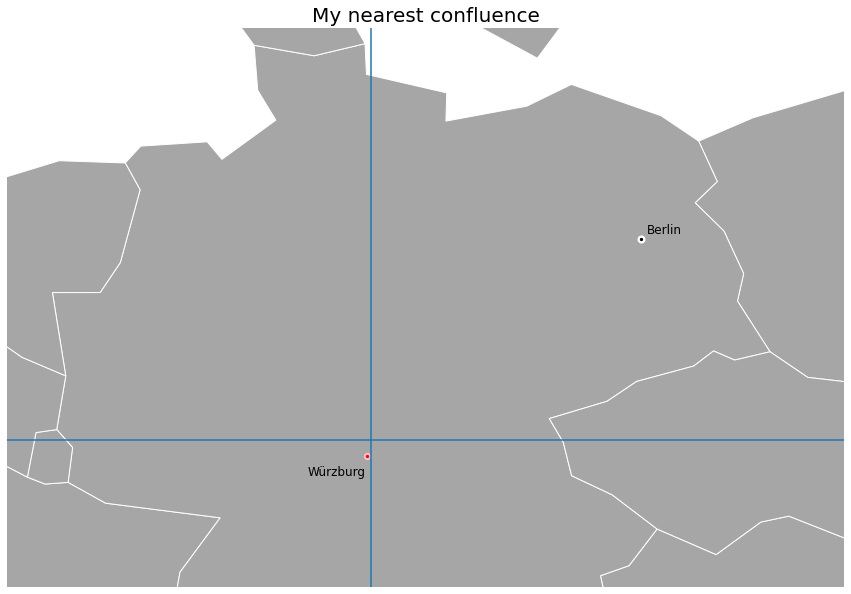

In [55]:
fig, ax = plt.subplots(figsize=(15, 15))
labels = []

xlim = [5.42, 15.95]
ylim = [48.15, 55.18]
ax.set_xlim(xlim)
ax.set_ylim(ylim)

berlin = cities.loc[cities.NAME == 'Berlin']

basemap = world.plot(ax=ax, color='#a6a6a6', edgecolor='white')

grid.plot(ax=ax)

berlin.plot(ax=ax, marker='o', color='white', markersize=50)
berlin.plot(ax=ax, marker='o', color='black', markersize=5)
plt.text(berlin.iloc[0].geometry.x+0.07, berlin.iloc[0].geometry.y+0.07, berlin.iloc[0].NAME, fontsize=12)


nearest_cities.plot(ax=ax, marker='o', color='pink', markersize=40)
nearest_cities.plot(ax=ax, marker='o', color='red', markersize=5)

for x, y, country, label in zip(nearest_cities.geometry.x, nearest_cities.geometry.y, nearest_cities["ADM0NAME"], nearest_cities["NAME"]):
    if country == 'Germany':
        plt.text(x-0.75, y-0.25, label, fontsize=12)

plt.axis('off')        
ax.set_title("My nearest confluence", fontsize=20)